In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
from torchaudio.transforms import MelSpectrogram, Resample
import os

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

##todo:
splitat u validation i u train set

In [5]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
12.1
1
NVIDIA GeForce GTX 1660


In [6]:
# Define a custom transform (Mel spectrogram transformation)
transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=400,        # 25 ms window
    hop_length=160,   # 10 ms stride
    n_mels=40
)

ako treba If you still need nn.Sequential later, wrap it like:

transform = nn.Sequential(
    MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=40)
)

In [7]:
# Example: simple character map (extend as needed)
char_map = {c: i+1 for i, c in enumerate("abcdefghijklmnopqrstuvwxyz '")}
char_map['<blank>'] = 0
output_size = len(char_map)
def text_to_int_sequence(text):
    return [char_map.get(c, 0) for c in text.lower()]

In [8]:
!pip install pyctcdecode


In [9]:
!pip install https://github.com/kpu/kenlm/archive/master.zip

  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build kenlm


  error: subprocess-exited-with-error
  
  × Building wheel for kenlm (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [73 lines of output]
      Will build with KenLM max_order set to 6
      <3>WSL (30 - Relay) ERROR: CreateProcessCommon:735: execvpe(/bin/bash) failed: No such file or directory
      <3>WSL (33 - Relay) ERROR: CreateProcessCommon:735: execvpe(/bin/bash) failed: No such file or directory
      <3>WSL (36 - Relay) ERROR: CreateProcessCommon:735: execvpe(/bin/bash) failed: No such file or directory
      running bdist_wheel
      running build
      running build_ext
      -- Building for: NMake Makefiles
      CMake Error at CMakeLists.txt:14 (project):
        Generator
      
          NMake Makefiles
      
        does not support platform specification, but platform
      
          x64
      
        was specified.
      
      
      CMake Error: CMAKE_C_COMPILER not set, after EnableLanguage
      CMake Error: CMAKE_CXX_COMPILER not set, after 

In [10]:
from pyctcdecode import BeamSearchDecoderCTC, Alphabet

labels = ["<pad>"] + list("abcdefghijklmnopqrstuvwxyz '")  # 29 labels total
alphabet = Alphabet.build_alphabet(labels)  # now index 0 is blank
decoder = BeamSearchDecoderCTC(alphabet)

kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


### što je dropout, zašto

promjena max poola na (2,1)
 Why we also changed stride=(2, 1)?
We usually want stride = kernel size in pooling.

This avoids overlapping windows and makes the output size predictable.

If you used:

python
Kopiraj
Uredi
kernel_size=(2, 2), stride=(2, 1)
You’d pool in time — but only move forward 1 step

That would result in overlapping pooling in time — more expensive

In [31]:
FIXED_INPUT_LENGTH = 8000  # or another value that fits your dataset
#FIXED_TIME_STEPS = 1024    # Adjust this based on your MelSpectrogram output and model
FIXED_TIME_STEPS = 512
class CNN_LSTM_Model(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, output_size=len(labels)):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool = nn.Identity()  # replaced MaxPool2d((2, 1)) to preserve time resolution
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(0.2)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # ⚠️ Dummy input to infer LSTM input size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 40, FIXED_TIME_STEPS)  # [B, C, Freq, Time]
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy))))
            x = torch.relu(self.bn2(self.conv2(x)))
            _, channels, freq, _ = x.shape
            lstm_input_size = channels * freq

        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)

        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = torch.relu(self.bn2(self.conv2(x)))

        batch, channels, freq, time = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(batch, time, channels * freq)

        lstm_out, _ = self.lstm(x)

        intermediate_logits = self.fc(lstm_out)  # shape: [B, T, vocab]
        final_output = self.dropout(intermediate_logits)

        return final_output.permute(1, 0, 2), intermediate_logits.permute(1, 0, 2)


In [32]:
# Define CTC Loss function
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

In [33]:
class LibriSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset="train-clean-100", transform=None, max_duration=10.0):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.data = []

        max_chars = 60 

        subset_dir = os.path.join(self.root_dir, subset)
        for speaker in os.listdir(subset_dir):
            speaker_path = os.path.join(subset_dir, speaker)
            if os.path.isdir(speaker_path):
                for chapter in os.listdir(speaker_path):
                    chapter_path = os.path.join(speaker_path, chapter)
                    if os.path.isdir(chapter_path):
                        trans_file = os.path.join(chapter_path, f"{speaker}-{chapter}.trans.txt")
                        audio_files = [f for f in os.listdir(chapter_path) if f.endswith('.flac')]
                        
                        # Load all transcriptions
                        trans_dict = {}
                        with open(trans_file, 'r') as f:
                            for line in f:
                                parts = line.strip().split(' ', 1)
                                if len(parts) == 2:
                                    trans_dict[parts[0]] = parts[1].lower()

                        for audio_file in audio_files:
                            audio_path = os.path.join(chapter_path, audio_file)
                            waveform, sample_rate = torchaudio.load(audio_path)
                            duration = waveform.shape[1] / sample_rate
                            utt_id = audio_file.replace('.flac', '')
                            transcription = trans_dict.get(utt_id, "")
                            if duration <= max_duration and len(transcription) <= max_chars:
                                self.data.append({
                                    'audio': audio_path,
                                    'transcription': transcription
                                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        waveform, sample_rate = torchaudio.load(sample['audio'])
        waveform = waveform.squeeze(0)
        if self.transform:
            spectrogram = self.transform(waveform)
            spectrogram = spectrogram.unsqueeze(0)
            return spectrogram, sample['transcription']
        return waveform.unsqueeze(0), sample['transcription']


In [34]:
import torch
import torch.nn.functional as F
FIXED_TIME_STEPS = FIXED_TIME_STEPS

def pad_waveform(waveform, target_length=FIXED_INPUT_LENGTH):
    # waveform shape: [channels, time] or [1, time]
    waveform_length = waveform.size(1)
    if waveform_length < target_length:
        padding = target_length - waveform_length
        waveform = F.pad(waveform, (0, padding))
    elif waveform_length > target_length:
        waveform = waveform[:, :target_length]
    return waveform


def resize_spec(spec, target_width=FIXED_TIME_STEPS):
    current_width = spec.shape[-1]
    if current_width < target_width:
        return F.pad(spec, (0, target_width - current_width))
    else:
        return spec[..., :target_width]
def collate_fn(batch):
    spectrograms = [resize_spec(item[0]) for item in batch]
    transcripts = [item[1] for item in batch]

    spectrograms = torch.stack(spectrograms)  # shape: [B, 1, 40, FIXED_TIME_STEPS]

    # Targets
    targets = []
    target_lengths = []
    for t in transcripts:
        int_seq = text_to_int_sequence(t)
        targets.extend(int_seq)
        target_lengths.append(len(int_seq))

    targets = torch.tensor(targets, dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return spectrograms, targets, target_lengths


## DONT FORGET TO RELOAD DATALOADER IF YOU FILTER FOR LENGTH ILI NEŠTO DRUGO

In [15]:
dataset = LibriSpeechDataset(
    root_dir=r"X:\AIx\PROJECTS\voiceToText\mojModel\data\LibriSpeech",
    subset="train-clean-100",
    transform=transform
)


In [35]:
print(f"Total filtered samples: {len(dataset)}")

Total filtered samples: 1454


In [36]:
from torch.utils.data import random_split

val_split = 0.1  # 10% for validation
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [38]:
model = CNN_LSTM_Model(hidden_size=128, num_layers=2, output_size=output_size).to(device)
# Run one batch through model to initialize LSTM/FC
inputs, _, _ = next(iter(train_loader))
print("Shape before model:", inputs.shape)  # should be [B, 1, 40, T]
_ = model(inputs.to(torch.float32).to(device))
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-3) # ovo je za overfitting test
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20)





Shape before model: torch.Size([16, 1, 40, 512])


In [39]:
inv_char_map = {v: k for k, v in char_map.items()}

def decode_prediction(pred):
    decoded = []
    prev = -1
    for p in pred:
        if p != prev and p != 0:  # Skip blank (0)
            decoded.append(labels[p])
        prev = p
    return ''.join(decoded)

def decode_target(target_seq):
    return ''.join(inv_char_map.get(t, '?') for t in target_seq if t != 0)

In [21]:
!pip install jiwer


treba fine tuneat, ako je target_length veći od output_time_steps ni dobro

In [40]:
def reset_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear, nn.LSTM)):
        m.reset_parameters()

model.apply(reset_weights)

CNN_LSTM_Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): Identity()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(2560, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=29, bias=True)
)

In [46]:
checkpoint = torch.load("checkpoint_full_epoch_750.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch'] + 1

C:\Users\User\AppData\Local\Temp\ipykernel_21944\3267170467.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_full_epoch_750.pt")


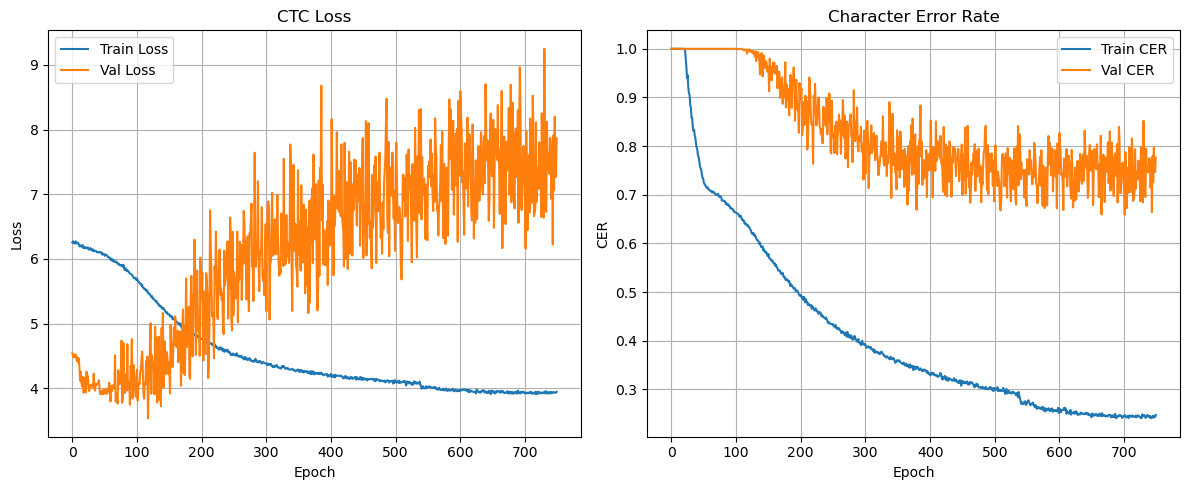


Epoch 750
Train Loss: 3.9436, CER: 0.2475
Val   Loss: 7.8632, CER: 0.7760


In [ ]:
from tqdm import tqdm
from jiwer import cer
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Init early stopping
best_val_cer = float('inf')
epochs_no_improve = 0
early_stop_patience = 8
checkpoint_path = "best_model.pt"

epoch_losses = []
epoch_cers = []
val_losses = []
val_cers = []

model.train()

for epoch in range(500):  # adjust number of epochs as needed
    running_loss = 0.0
    cer_scores = []

    # === TRAINING ===
    for batch_idx, (inputs, targets, target_lengths) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        inputs = inputs.to(torch.float32).to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()
        outputs, intermediate = model(inputs)
        log_probs = torch.nn.functional.log_softmax(outputs, dim=-1)
        log_probs_mid = torch.nn.functional.log_softmax(intermediate, dim=-1)

        input_lengths = torch.full((inputs.size(0),), log_probs.size(0), dtype=torch.long, device=device)

        loss_main = ctc_loss(log_probs, targets, input_lengths, target_lengths)
        loss_aux = ctc_loss(log_probs_mid, targets, input_lengths, target_lengths)
        loss = loss_main + 0.3 * loss_aux  # ✅ Weighted auxiliary loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = log_probs.argmax(-1).T  # shape: [batch, time]
        target_offset = 0
        for i in range(preds.shape[0]):
            pred_str = decode_prediction(preds[i].tolist())
            true_len = target_lengths[i].item()
            target_str = decode_target(targets[target_offset:target_offset + true_len].tolist())
            target_offset += true_len
            cer_scores.append(cer(target_str, pred_str))

    average_loss = running_loss / len(train_loader)
    average_cer = sum(cer_scores) / len(cer_scores)
    epoch_losses.append(average_loss)
    epoch_cers.append(average_cer)

    scheduler.step(average_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    val_cer_scores = []

    with torch.no_grad():
        for inputs, targets, target_lengths in val_loader:
            inputs = inputs.to(torch.float32).to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            outputs, intermediate = model(inputs)
            log_probs = torch.nn.functional.log_softmax(outputs, dim=-1)
            log_probs_mid = torch.nn.functional.log_softmax(intermediate, dim=-1)

            input_lengths = torch.full((inputs.size(0),), log_probs.size(0), dtype=torch.long, device=device)
            loss_main = ctc_loss(log_probs, targets, input_lengths, target_lengths)
            loss_aux = ctc_loss(log_probs_mid, targets, input_lengths, target_lengths)
            loss = loss_main + 0.3 * loss_aux  # Weighted auxiliary loss
            val_loss += loss.item()

            preds = log_probs.argmax(-1).T
            target_offset = 0
            for i in range(preds.shape[0]):
                pred_str = decode_prediction(preds[i].tolist())
                true_len = target_lengths[i].item()
                target_str = decode_target(targets[target_offset:target_offset + true_len].tolist())
                target_offset += true_len
                val_cer_scores.append(cer(target_str, pred_str))

    avg_val_loss = val_loss / len(val_loader)
    avg_val_cer = sum(val_cer_scores) / len(val_cer_scores)
    val_losses.append(avg_val_loss)
    val_cers.append(avg_val_cer)

    # === EARLY STOPPING ===
    if avg_val_cer < best_val_cer:
        best_val_cer = avg_val_cer
        epochs_no_improve = 0
        torch.save(model.state_dict(), checkpoint_path)
        print("✅ Saved best model.")
    

    # === LIVE PLOT ===
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("CTC Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_cers, label='Train CER')
    plt.plot(val_cers, label='Val CER')
    plt.title("Character Error Rate")
    plt.xlabel("Epoch")
    plt.ylabel("CER")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nEpoch {epoch + 1}")
    print(f"Train Loss: {average_loss:.4f}, CER: {average_cer:.4f}")
    print(f"Val   Loss: {avg_val_loss:.4f}, CER: {avg_val_cer:.4f}")

    model.train()  # back to training mode for next epoch


In [45]:
#cijeli checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': epoch_losses,
    'val_loss': val_losses
}, f"checkpoint_full_epoch_750.pt")